# Bibliotecas

In [20]:
import os

try:
    import wget
except:
    !pip install wget
    import wget

import matplotlib.pyplot as plt
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import cv2 as cv

In [21]:
#This function creates a figure to show subplots automatically
def show_subplot(images, titles, gridFormat, figSize=(6, 6), cmap="gray", output_fig_name="output.png", export=False):
    fig = plt.figure(figsize=figSize, dpi=150)
    st = fig.suptitle(output_fig_name, fontsize="large")

    for idx, image in enumerate(images):
        idx_curr_img = int(str(gridFormat[0]) + str(gridFormat[1]) + str(idx+1))
        plt.subplot(idx_curr_img).set_title(titles[idx])
        plt.subplot(idx_curr_img).axis('off')
        plt.imshow(image, cmap=cmap)

    fig.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)

    if export:
        plt.savefig(output_fig_name, dpi=300)

    plt.show()

In [22]:
#This function load images using IMAGEIO library
def load_image_imageio(path_img, resize=None):
    img = imageio.imread(path_img)

    if resize:
        resCols, resRows = resize
        img = Image.fromarray(img).resize((resCols, resRows))

    return np.array(img)

In [23]:
#This function load and converts '.pfm' files into images
def load_pfm_files(path_file, resize=None, normalize=None):
    #Reference: https://copyprogramming.com/howto/opencv-how-to-read-pfm-files

    #Load input data
    pfm_img = cv.imread(path_file, cv.IMREAD_UNCHANGED)

    # Remove infinite value to display
    pfm_img[pfm_img==np.inf] = 0

    if resize:
        resCols, resRows = resize
        pfm_img = cv.resize(pfm_img,
                           (resCols, resRows),
                            interpolation = cv.INTER_LINEAR) #Image.fromarray(pfm_img).resize((resCols, resRows))

    # Normalize
    if normalize:
        min, max = 0, 255
        pfm_img = cv.normalize(pfm_img, None, min, max, cv.NORM_MINMAX).astype(np.float32)

    return pfm_img

# GET AND PROCESS INPUT DATA

In [24]:
#Set parameters
new_size = (512,512)    # Images resolution
features_technique = 3  # 1) Grayscale, 2) RGB, 3) Raft Stereo, 4) Mobile Net

path_imgL = "im0.png"
path_imgR = "im1.png"

path_gt_L = "disp0.pfm"
path_gt_R = "disp1.pfm"

In [25]:
# DATASET: https://vision.middlebury.edu/stereo/data/scenes2014/datasets/
url = 'https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Flowers-perfect/'
if not os.path.isfile(path_imgL):
    wget.download(url+path_imgL)
if not os.path.isfile(path_imgR):
    wget.download(url+path_imgR)
if not os.path.isfile(path_gt_L):
    wget.download(url+path_gt_L)
if not os.path.isfile(path_gt_R):
    wget.download(url+path_gt_R)

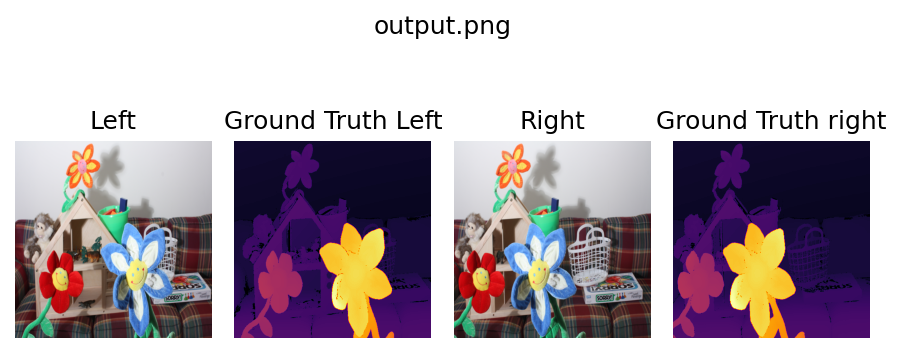

In [26]:
#Load Images
imgL = load_image_imageio(path_imgL, resize=new_size)
imgR = load_image_imageio(path_imgR, resize=new_size)

#Load Ground Truth
gt_L = load_pfm_files(path_gt_L, resize=new_size)
gt_R = load_pfm_files(path_gt_R, resize=new_size)

#Show images side-by-side
show_subplot(images=[imgL, gt_L, imgR, gt_R],
             titles=["Left", "Ground Truth Left", "Right", "Ground Truth right"],
             gridFormat=(1, 4),
             figSize=(6, 3),
             cmap="inferno")

# Fourier Analysis

In [17]:
### GENERAL INFORMATION #######################################################
#   Name:           Sherlon Almeida da Silva                                  #
#   USP number:     11361585                                                  #
#   course code:    SCC5830                                                   #
#   Year/Semestre:  2024/1                                                    #
#   Title:          Assignment 2 : Filtering in Spatial and Frequency Domain  #
###############################################################################

###### Useful Libraries ##############################
import numpy as np                                   #
import imageio.v3 as imageio                         #
import matplotlib.pyplot as plt                      #
######################################################

"""Implementacao da versao 2D do DFT"""
def DFT2D(f):
    # create empty array of complex coefficients
    F = np.zeros(f.shape, dtype=np.complex64)
    n,m = f.shape[0:2]

    # creating indices for x, to compute multiplication using numpy (f*exp)
    x = np.arange(n)
    # for each frequency 'u,v'
    for u in np.arange(n):
        for v in np.arange(m):
            for y in np.arange(m):
                F[u,v] += np.sum(f[:,y] * np.exp( (-1j*2*np.pi) * (((u*x)/n)+((v*y)/m)) ))
    return F/np.sqrt(n*m)

"""Implementacao da versao 2D do Inverse DFT"""
def IDFT2D(F):
    # create empty array of complex coefficients
    f = np.zeros(F.shape, dtype=np.int32)
    n,m = F.shape[0:2]

    # creating indices for x, to compute multiplication using numpy (f*exp)
    u = np.arange(n)
    # for each frequency 'u,v'
    for x in np.arange(n):
        for y in np.arange(m):
            for v in np.arange(m):
                f[x,y] += np.real(np.sum(F[:,v] * np.exp( (1j*2*np.pi) * (((u*x)/n)+((v*y)/m)) )))

    return np.real(f/np.sqrt(n*m))

"""Retorna a imagem filtrada no dominio de frequencia"""
def filtering(img, my_filter):
    filtered = np.multiply(img, my_filter)
    return filtered

"""Retorna a imagem no dominio de frequencia"""
def get_frequency_domain(img):
    img_freq_domain = np.fft.fftshift(np.fft.fft2(img))
    return img_freq_domain

"""Retorna a imagem no dominio espacial"""
def get_spatial_domain(img):
    img_spat_domain = np.fft.ifft2(np.fft.ifftshift(img)).real
    return img_spat_domain

"""Calcula o erro"""
def rms_error(img, out):
    M,N = img.shape
    error = ((1/(M*N))*np.sum((img.astype(np.int32)-out.astype(np.int32))**2))**(1/2)
    return error

"""Normaliza entradas entre 0 e 1, depois converte entre 0 e 255"""
def normalize_values(img):
    imax = np.max(img)
    imin = np.min(img)
    img_norm = (img-imin)/(imax-imin)
    img_norm = (img_norm * 255).astype(np.int32)
    return img_norm

def filter_low_pass(P, Q):
    r = float(input().rstrip()) #Obtem o raio

    D = np.zeros([P, Q]) #Compute Distances
    for u in range(P):
        for v in range(Q):
            D[u,v] = np.sqrt( (u-(P/2))**2 + (v-(Q/2))**2 )

    M = np.zeros([P, Q])
    M[ np.where(D <= r) ] = 1
    return M

def filter_high_pass(P, Q):
    r = float(input().rstrip()) #Obtem o raio

    D = np.zeros([P, Q]) #Compute Distances
    for u in range(P):
        for v in range(Q):
            D[u,v] = np.sqrt( (u-(P/2))**2 + (v-(Q/2))**2 )

    M = np.ones([P, Q])
    M[ np.where(D <= r) ] = 0
    return M

def filter_band_stop(P, Q):
    r0 = float(input().rstrip()) #Obtem o raio 0 (mais externo - maior)
    r1 = float(input().rstrip()) #Obtem o raio 1 (mais interno - menor)

    D = np.zeros([P, Q]) #Compute Distances
    for u in range(P):
        for v in range(Q):
            D[u,v] = np.sqrt( (u-(P/2))**2 + (v-(Q/2))**2 )

    M = np.ones([P, Q])
    M[ np.where(D <= r0) ] = 0 #Remove tudo dentro do Raio Externo
    M[ np.where(D <= r1) ] = 1 #Adicionar tudo dentro do Raio Interno
    return M

def filter_laplacian(P, Q):
    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            D[u, v] = (-4*np.pi**2) * ( (u-(P/2))**2 + (v-(Q/2))**2 )
    return D

def filter_gaussian(P, Q):
    s1 = float(input().rstrip()) #Obtem o sigma 1
    s2 = float(input().rstrip()) #Obtem o sigma 2

    D = np.zeros([P, Q])  # Compute Distances
    for u in range(P):
        for v in range(Q):
            x = (u-(P/2))**2/(2*s1**2) + (v-(Q/2))**2/(2*s2**2)
            D[u, v] = np.exp(-x)
    return D

"""The filters for the Frequency domain must have the image size"""
def create_filter(P, Q, f_id):
    #Defines the available filters
    curr_filter = [filter_low_pass, filter_high_pass, filter_band_stop, filter_laplacian, filter_gaussian]

    #Compute the desired filter
    M = curr_filter[f_id](P, Q)

    return M

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(np.int32)

<ipython-input-18-0b3bfe8a1d2a>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  ax[1,0].imshow(np.log(1 + get_frequency_domain(rgb2gray(imgL))).astype(np.int32), cmap="gray")
<ipython-input-18-0b3bfe8a1d2a>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  ax[1,1].imshow(np.log(1 + get_frequency_domain(rgb2gray(imgR))).astype(np.int32), cmap="gray")


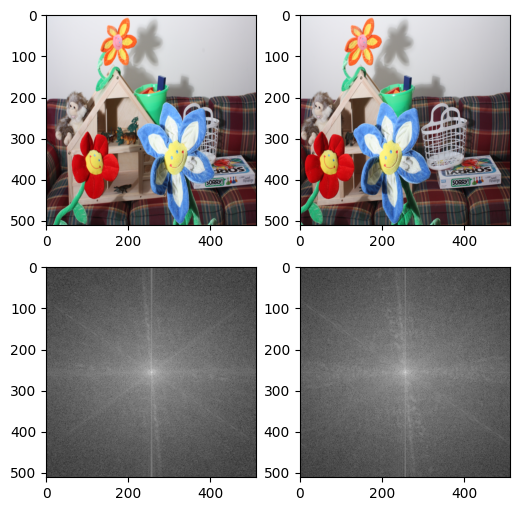

In [18]:
#Show images side-by-side
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
ax[0,0].imshow(imgL)
ax[0,1].imshow(imgR)
ax[1,0].imshow(np.log(1 + get_frequency_domain(rgb2gray(imgL))).astype(np.int32), cmap="gray")
ax[1,1].imshow(np.log(1 + get_frequency_domain(rgb2gray(imgR))).astype(np.int32), cmap="gray")
plt.show()

<ipython-input-19-5b917f9b98fb>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  ax[1,0].imshow(np.log(1 + get_frequency_domain(gt_L)).astype(np.int32), cmap="gray")
<ipython-input-19-5b917f9b98fb>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  ax[1,1].imshow(np.log(1 + get_frequency_domain(gt_R)).astype(np.int32), cmap="gray")


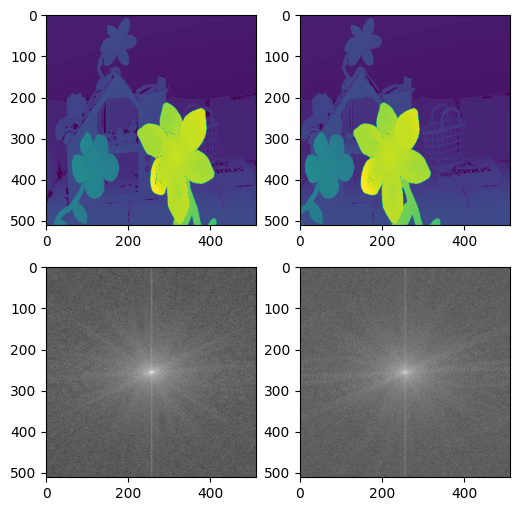

In [19]:
#Show images side-by-side
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
ax[0,0].imshow(gt_L)
ax[0,1].imshow(gt_R)
ax[1,0].imshow(np.log(1 + get_frequency_domain(gt_L)).astype(np.int32), cmap="gray")
ax[1,1].imshow(np.log(1 + get_frequency_domain(gt_R)).astype(np.int32), cmap="gray")
plt.show()